# FSL-MRS fMRS fitting demo 
<img src="extras/fsl-logo.png">

## 1) Introduction

In this demo, we will fit simulated spectra from a functional MRS experiment, where multiple transients are acquired while a stimulus is turned on and off, leading to changes in some metabolite concentrations, alongside changes in the line shapes due to the BOLD effect.

The objective is to learn how to perform "dynamic fitting", i.e. fitting all the spectra at once, while specifying an explicit parametrised model for the spectra time courses. 

But before we do that, let us first load the data, visualise the data, and do a quick fit to the data to check that our modelling has a chance to work.

In [1]:
from fsl_mrs.utils import mrs_io

# data represents a NIfTI-MRS file in memory
data = mrs_io.read_FID('simulated_data/sub0_stim.nii.gz')

# what's in the data? 
print(data.shape)

(1, 1, 1, 1024, 64)


This is a single voxel data set (the first dimensions are x,y,z). It has 1024 time points and 64 transients (time-steps). 

We can visualise the data using fsl-mrs plotting tools. We will first visualise the time series with the dynamic plotting, and then visualise the average time course.

In [2]:
from fsl_mrs.utils import plotting as plot

# Note: calling data.mrs() generates an MRS object, which is the core
# class in FSL-MRS 
plot.plotly_dynMRS(data.mrs())


Now let us create an average spectrum, load our basis spectra (for fitting), and make an initial attempt at fitting to check that all is well.

In [3]:

import warnings
warnings.filterwarnings('ignore')
import fsl_mrs.utils.preproc.nifti_mrs_proc as proc

# Average data over the dynamic dimension
data_avg = proc.average(data,'DIM_DYN')

# Do a quick fit to the average data
mrs     = data_avg.mrs(basis_file='basis')
results = mrs.fit()

fig = plot.plotly_fit(mrs,results)
fig

## 2) Experiment

Now we describe the experimental setup for these simulated data. This will be useful in order to create a design matrix for the fitting. 

Four blocks of stimulation (here modelled as visual stimulation) were administered during the scan to the subject and this was repeated twice: once with eyes open (`sub{i}_stim`), once with eyes closed (`sub{i}_ctrl`). The pattern of the stimulus was OFF-ON-OFF-ON. Each block was 64s long with a TR of 4s.

<p><img src="extras/stim.png" width=500px></p>


## 3) Setting up the fitting

We need two things to do dynamic fitting:

- Design matrix
- Model specification

The design matrix contains regressors that aim to capture the variations in parameters (such as concentrations) over time. We draw from the world of FMRI and use tools designed for FMRI analysis (Nilearn) to create a design matrix. 

The model specification comes in the form of a text file which specifies the dynamic model for each parameter. 

Let's first create the design matrix with Nilearn.



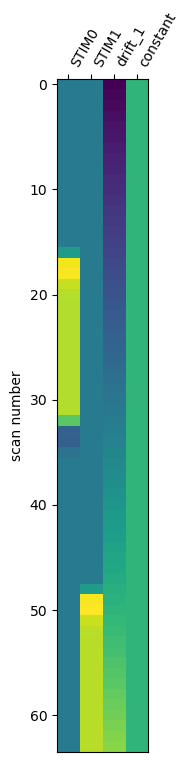

In [4]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

import numpy as np
import pandas as pd

# Calculations to create the design matrix
tr          = 4.0  # repetition time in seconds
n_blocks    = 2    # Number of stimulation blocks
n_scans     = 64   # Total number of scan points
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = [16.*tr,] * n_blocks # Duration of each stimulation block
onsets = [tr*15.+tr*32.*k for k in np.arange(0, n_blocks)] # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=1, 
    hrf_model='glover') 

# Plot the designmatrix for inspection
_ = plot_design_matrix(design_matrix)



Now is the time to talk about the configuration file which specifies the dynamic model.

Firsly, you need to know the model that underlies the fitting in FSL-MRS. The model is explained [here](https://open.win.ox.ac.uk/pages/fsl/fsl_mrs/fitting.html#details).

The model contains a bunch of parameters (for concentrations, phase, lineshape, and baseline). In the dynamic fitting, each of these parameters can get their own dynamic model.

Here, we use a simple linear model, controlled with the design matrix we created above. We apply this linear model to the concentrations as well as the linewidth parameters, to account for the BOLD effect.

The cell below creates a configuration file and saves it to disk.




In [5]:
%%writefile fmrs_model.py
from numpy import dot

# Parameter - functional relationships
Parameters = {
    'conc'     : {'dynamic': 'model_glm', 'params': [f'beta{i}' for i in range(4)]},
    'gamma'    : 'fixed',
    'sigma'    : {'dynamic': 'model_glm', 'params': [f'beta{i}' for i in range(4)]},
    'eps'      : 'fixed',
    'baseline' : 'fixed',
    'Phi_0'    : 'fixed',
    'Phi_1'    : 'fixed'}

# Bounds on free fitted parameters
Bounds = {
    'gamma': (0, None),
    'beta3': (0, None)}


# Dynamic models
def model_glm(p, t):
    return dot(t, p)


# Dynamic model gradients
def model_glm_grad(p, t):
    return t.T


Overwriting fmrs_model.py


## Performing the fit

For the fitting, we simply create a dynMRS object and provide the config file for fitting

We define a couple of additional parameters that control aspects of the spectral fit:
1. `metab_groups`: Defines that the macromolecule basis spectrum needs special handling
2. `baseline_order`: Low order polynomial baseline model to match data simulation.

In [6]:

from fsl_mrs.dynamic import dynMRS

mrslist = data.mrs(basis_file='basis')

spectral_fitargs = {
    'metab_groups'   : mrslist[0].parse_metab_groups('Mac'),
    'baseline_order' : 0}

dyn = dynMRS(
    mrslist,
    design_matrix.to_numpy(),
    config_file= 'fmrs_model.py',
    **spectral_fitargs)


We can either fit the result here or use the pre-generated results for speed.

Uncomment the line below to run the fitting rather than loading the results.

In [7]:
# Uncomment to run fitting
# dyn_res = dyn.fit()
# df_dyn_sub0 = pd.concat((dyn_res.mean_free, dyn_res.std_free), axis=1, keys=['mean', 'sd'])

# OR Load pre-generated
df_dyn_sub0 = pd.read_csv('first_level_results/sub0/stim/free_parameters.csv', index_col=0)

## Results at a single subject level

Load data from fit of the original data, both un-averaged and windowed average, for comparison during plotting.

In the `gen_and_fit_window_avg_data.ipynb` notebook we have performed windowed averaging of the data before fitting the averages independently. This somewhat simulates analysis approaches used before. Temporal resolution is lost and time points become correlated complicating further analysis. However, SNR is substantially improved over the raw data.

In [15]:
import pandas as pd

df_indep_stim = pd.read_csv('windowed_avg_results/sub0_stim.csv', index_col=0)
df_wavg_stim = pd.read_csv('windowed_avg_results/sub0_stim_wavg.csv', index_col=0)

Plot

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

met = 'Glu'

x_axis = np.arange(64)

design_matrix = pd.read_csv('designmat.csv',header=None).to_numpy()

def indiv_traces(metab, percent=True):
    p = df_dyn_sub0.filter(regex=metab, axis=0)['mean'].values
    val = np.dot(p, design_matrix.T)
    if percent:
        val = 100 * val/val.mean() - 100
    return val

colors = plt.get_cmap('tab10').colors
def color_t2s(tin, alpha=1):
    tscaled = [255*t for t in tin]
    return f'rgba({tscaled[0]}, {tscaled[1]}, {tscaled[2]}, {alpha})'
line_size = dict(idep=1, wavg=2, dyn=3)

mean_metab = df_indep_stim[met].mean()
def to_percent(x):
    return 100 * ((x/mean_metab) - 1)

indep_trace = go.Scatter(
    x=x_axis, y=to_percent(df_indep_stim[met]),
    mode='lines+markers',
    name=f'{met}: independent',
    legendgroup=met,
    line=dict(
        color=color_t2s(colors[0]),
        width=line_size['idep']),
                )

wav_trace = go.Scatter(
    x=x_axis, y=to_percent(df_wavg_stim[met]),
    mode='lines',
    name=f'{met}: window avg',
    legendgroup=met,
    line=dict(
        color=color_t2s(colors[1]),
        width=line_size['wavg']),
                )

regex = '_' + met.replace('+', '\+') + '_'
dyn_trace = go.Scatter(
    x=x_axis, y=indiv_traces(regex),
    mode='lines',
    name=f'{met}: dynamic',
    legendgroup=met,
    line=dict(
        color=color_t2s(colors[2]),
        width=line_size['dyn']),
                )

fig = go.Figure()
fig.add_trace(indep_trace)
fig.add_trace(wav_trace)
fig.add_trace(dyn_trace)
fig.update_layout(template='plotly_white')

## Second Level (Group) Analysis

We can repeat the above processing for each subject, which we demonstrate in the script `first_level_fit.py`. This results in a directory structure with results for both stimulated and control cases for each of the 10 subjects.

In FSL for fMRI we could now run a group analysis with the higher-level tools present in FSL FEAT. FSL-MRS has an interface that uses the component tools of FSL to achieve this for fMRS.

This tool is `fmrs_stats`. It runs FSL FLAME to carry out higher level group analysis on the single subject results, it also offers the opportunity to form contrasts and combine correlated peaks at the first level before running the group stats.

You can run `fmrs_stats` on the command line. You will need to provide design matrices for the group level analysis and information on any first level contrasts.

Let's look at the first level contrasts - where we form a mean activation COPE. We will also combine some peaks as listed on the command-line call a couple of cells below.

In [17]:
%%writefile fl_contrasts.json
[
        {
            "name": "mean_activation",
            "betas": ["beta0", "beta1"],
            "scale": [0.5, 0.5]
        }
]

Overwriting fl_contrasts.json


And now the group level contrasts. Here we describe a paired t-test between the stim and ctrl condition. On the command-line call we will give these contrasts names: `"STIM>CTRL"` & `"CTRL>STIM"`.

In [18]:
import numpy as np
des_mat = np.zeros((20,11), int)
des_mat[:10, 0] = 1
des_mat[10:, 0] = -1
des_mat[:10, 1:] = np.eye(10)
des_mat[10:, 1:] = np.eye(10)
print(des_mat)
np.savetxt('pttest_design', des_mat)

%sx Text2Vest pttest_design design.mat

con_mat = np.zeros((2,11), int)
con_mat[0, 0] = 1
con_mat[1, 0] = -1
print(con_mat)
np.savetxt('pttest_contrasts', con_mat)

%sx Text2Vest pttest_contrasts design.con

[[ 1  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0  0  1]
 [-1  1  0  0  0  0  0  0  0  0  0]
 [-1  0  1  0  0  0  0  0  0  0  0]
 [-1  0  0  1  0  0  0  0  0  0  0]
 [-1  0  0  0  1  0  0  0  0  0  0]
 [-1  0  0  0  0  1  0  0  0  0  0]
 [-1  0  0  0  0  0  1  0  0  0  0]
 [-1  0  0  0  0  0  0  1  0  0  0]
 [-1  0  0  0  0  0  0  0  1  0  0]
 [-1  0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  0  0  0  1]]
[[ 1  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0]]


[]

In [19]:
%%sx
fmrs_stats\
    --data results_list\
    --output cmd_group_res\
    --fl-contrasts fl_contrasts.json\
    --combine NAA NAAG\
    --combine Cr PCr\
    --combine PCh GPC\
    --combine Glu Gln\
    --hl-design design.mat\
    --hl-contrasts design.con\
    --hl-contrast-names "STIM>CTRL" "CTRL>STIM"\
    --overwrite

[]

Once run, we can look at the results. For more information on the second level anlaysis, see `second_level_analysis.ipynb`.

In [20]:
import pandas as pd
# Load the results
cmd_line_df = pd.read_csv('cmd_group_res/group_stats.csv',index_col=0, header=[0,1])

# Format for display, only show mean activation, and drop combined metabolites.
cmd_line_df.filter(regex='mean_activation', axis=0)\
.drop(['conc_NAA_mean_activation',
       'conc_NAAG_mean_activation',
       'conc_Cr_mean_activation',
       'conc_PCr_mean_activation',
       'conc_PCh_mean_activation',
       'conc_GPC_mean_activation'])\
.style\
.format(formatter={('z', 'STIM>CTRL'):    "{:+05.2f}", ('z', 'CTRL>STIM'):    "{:+05.2f}",
                   ('p', 'STIM>CTRL'):    "{:05.3f}", ('p', 'CTRL>STIM'):    "{:05.3f}"})\
.highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')